# Projet MOGPL: la balade du robot

### Sportich Benjamin, de Bézenac Emmanuel

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import numpy as np

## GENERATION ALEATOIRE D'INSTANCES

## LECTURE DE FICHIER

In [2]:
def readfile(filename):
    with open(filename) as f:
        M,N = [int(x) for x in f.readline().split()] # read first line
        array = []
        i=0
        for line in f: # read rest of lines
            if(i<M):
                array.append(np.array([int(x) for x in line.split()]))
                i+=1
            else:
                iStart,jStart,iEnd,jEnd=[int(line.split()[i]) for i in range(4)]
                startDir=line.split()[4]
                break
    return M,N,np.array(array),iStart,jStart,iEnd,jEnd,startDir

Exemple:

In [3]:
m,n,A,iS,jS,iE,jE,sD=readfile('entree.txt')

## CREATION & GESTION DU GRAPHE

### Génère le graphe en fonction du tableau d'obstacles

In [65]:
def is_obstacle(i,j,M,N,A):
    #Cas Limites
    if(i==0):
        if(j==0):
            return A[0][0]
        if(j>0 and j<=N):
            return A[0][j-1]         
    if(i==M):
        if(j==0):
            return A[M-1][0]
        if(j>0 and j<=N):
            return A[M-1][N-1]
    if(j==0):
        if(i>0 and i<=M):
            return A[i-1][0]         
    if(j==N):
        if(i==0):
            return A[0][N-1]
        if(i>0 and i<=M):
            return A[M-1][N-1]
    #Cas General
    if( i>=1 and j>=1 and i<M and j<N and A[i-1][j-1]==0 and A[i][j-1]==0 and A[i-1][j]==0 ):
        return A[i][j]
    return 1 

def gen_graph(M,N,A):
    G=nx.DiGraph()
    for i in range(M+1):
        for j in range(N+1):
            print i,j
            if(is_obstacle(i,j,M,N,A)==False):              
                #Creation des noeuds - un par direction = 4 par position                
                G.add_node(str(i)+str(j)+'1',direct='N')
                G.add_node(str(i)+str(j)+'2',direct='E')
                G.add_node(str(i)+str(j)+'3',direct='S')
                G.add_node(str(i)+str(j)+'4',direct='O')

                #Creation des arcs
                #Changement de direction                
                G.add_edge(str(i)+str(j)+'1',str(i)+str(j)+'2',action='R')
                G.add_edge(str(i)+str(j)+'1',str(i)+str(j)+'4',action='L')
                G.add_edge(str(i)+str(j)+'2',str(i)+str(j)+'3',action='R')
                G.add_edge(str(i)+str(j)+'3',str(i)+str(j)+'4',action='R')

                G.add_edge(str(i)+str(j)+'2',str(i)+str(j)+'1',action='L')
                G.add_edge(str(i)+str(j)+'4',str(i)+str(j)+'1',action='R')
                G.add_edge(str(i)+str(j)+'3',str(i)+str(j)+'2',action='L')
                G.add_edge(str(i)+str(j)+'4',str(i)+str(j)+'3',action='L')

                #Deplacement
                #Nord/Haut
                for k in [1,2,3]:
                    if(is_obstacle(i-k,j,M,N,A)==False):
                        G.add_edge(str(i)+str(j)+'1',str(i-k)+str(j)+'1',action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                #Est/Droite
                for k in [1,2,3]:
                    if(is_obstacle(i,j+k,M,N,A)==False):
                        G.add_edge(str(i)+str(j)+'2',str(i)+str(j+k)+'2',action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                
                #Sud/Bas
                for k in [1,2,3]:
                    if(is_obstacle(i+k,j,M,N,A)==False):
                        G.add_edge(str(i)+str(j)+'3',str(i+k)+str(j)+'3',action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                
                #Ouest/Gauche
                for k in [1,2,3]:
                    if(is_obstacle(i,j-k,M,N,A)==False):
                        G.add_edge(str(i)+str(j)+'4',str(i)+str(j-k)+'4',action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                        
    return G

## AFFICHAGE DU GRAPHE

In [66]:
def fixed_pos(G): #Assigne des positions aux noeuds du graphe
    fixed_pos={}
    for n in G.nodes():
        if(n[2]=='1'):
            fixed_pos[n]=(int(n[1])*4+1,int(n[0])*4)
        if(n[2]=='2'):
            fixed_pos[n]=(int(n[1])*4+2,int(n[0])*4+1)
        if(n[2]=='3'):
            fixed_pos[n]=(int(n[1])*4+1,int(n[0])*4+2)
        if(n[2]=='4'):
            fixed_pos[n]=(int(n[1])*4,int(n[0])*4+1)        
    return fixed_pos
    
def draw_graph(G,pos,ax,sg=None): #Genere l'affichage du graphe
    for n in G:
        c=Circle(pos[n],radius=0.15,alpha=0.5)
        ax.add_patch(c)
        G.node[n]['patch']=c
        x,y=pos[n]
    seen={}
    for (u,v,d) in G.edges(data=True):
        n1=G.node[u]['patch']
        n2=G.node[v]['patch']
        rad=0.2
        if (u,v) in seen:
            rad=seen.get((u,v))
            rad=(rad+np.sign(rad)*0.1)*-1
        alpha=0.5
        color='k'
        e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
                            arrowstyle='-|>',
                            connectionstyle='arc3,rad=%s'%rad,
                            mutation_scale=10.0,
                            lw=2,
                            alpha=alpha,
                            color=color)
        seen[(u,v)]=rad
        ax.add_patch(e)
    return e

def show_graph(G): # affiche le graphe
    fig=plt.figure(figsize=(10,10))
    ax=plt.subplot(111)
    ax.invert_yaxis()
    draw_graph(G,fixed_pos(G),ax)
    ax.autoscale()
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    #plt.savefig("graph.pdf")
    #nx.draw_networkx(G,fixed_pos,ax=axe,arrows=True,node_size=400,font_size=10)
    #nx.draw(G,fixed_pos(G),ax=axe)

## Main

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
['201', '214', '132', '212', '213', '134', '313', '312', '311', '022', '144', '314', '133', '011', '012', '013', '014', '113', '112', '032', '033', '244', '031', '034', '204', '344', '101', '211', '441', '243', '404', '403', '104', '342', '343', '421', '423', '422', '424', '341', '124', '203', '202', '142', '143', '141', '443', '301', '302', '303', '304', '402', '242', '444', '003', '002', '001', '123', '021', '023', '004', '102', '103', '442', '044', '043', '042', '041', '121', '024', '401', '122', '414', '131', '241', '411', '412', '413', '114', '111', '434', '432', '433', '431']


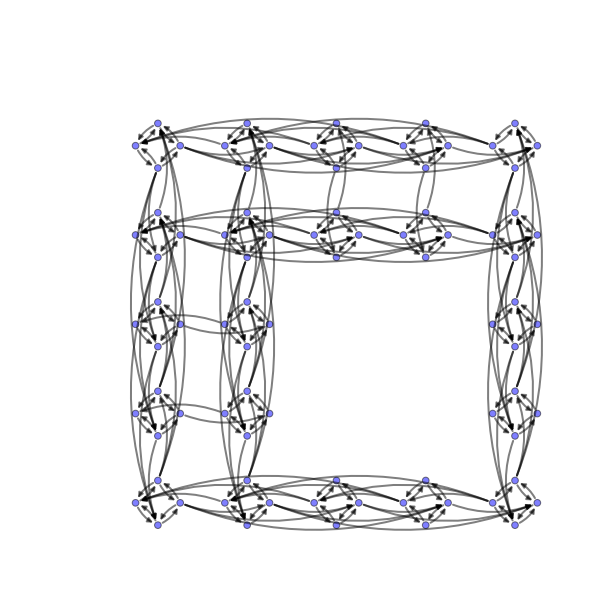

In [69]:
M,N=4,4
A=np.zeros((M,N))
A[2,2]=1
G=gen_graph(M,N,A)

#G.remove_node('1-14')
print G.nodes(data=False)
show_graph(G)

In [70]:
A

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.]])

## Interface

0 0
-2 -1 -1 0
-1 0 0 1
0 -1 1 0
-1 -2 0 -1
0 1
-1 0 0 1
0 2
-2 1 -1 2
-1 2 0 3
0 1 1 2
-1 0 0 1
1 0
0 -1 1 0
1 1
0 0 1 1
ok 0011
-1 0 0 1
0 1 1 2
1 0 2 1
0 -1 1 0
1 2
0 1 1 2
2 0
0 -1 1 0
1 0 2 1
2 -1 3 0
1 -2 2 -1
2 1
1 0 2 1
2 2
0 1 1 2
1 2 2 3
2 1 3 2
1 0 2 1


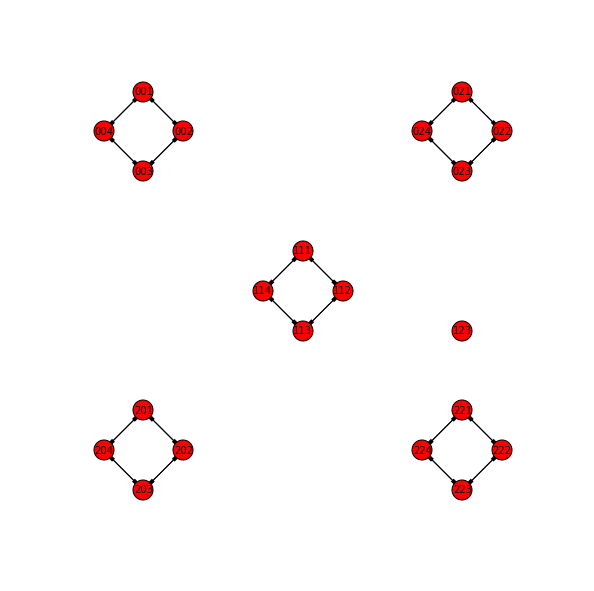

In [55]:
M2,N2=2,2
A=np.zeros((M2,N2))
G2=gen_graph(M2,N2,A)
fig=plt.figure(figsize=(10,10))
ax=plt.subplot(111)
ax.invert_yaxis()
ax.autoscale()
#G.add_edge('313','322')
G2.add_node('123')
nx.draw_networkx(G2,fixed_pos(G2),ax=ax,arrows=True,node_size=400,font_size=10)
#nx.draw(G,fixed_pos(G),ax=ax)
plt.axis('equal')
plt.axis('off')
plt.show()
